# Figure 1 (MF-Windspeed)

original draft of code: SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb

input data used:
    
    winds:
    baseDir = '//gpfs/data/greenocean/software/products/windsFromComponents/symlinked_hrly_UKESM/daily/'
    ty = f'{baseDir}/UKESM_{scen}_y{yrs[i]}_wspd10m_seas_rg.nc
    
    1x1deg meshmask:
    /gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc
    

In [95]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [96]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
from scipy import stats

import pymannkendall as mk

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from importlib import reload
import matplotlib.path as mpath
import glob
import pandas as pd


### colour and scenario definitions

In [97]:
scendict = {
    '1A': {
        'hist_str': 'bc370',
        'fut_str': 'be682',
        'name': 'HIST.OZONE \n LOW TEMP.',
        'name2':'realistic ozone, SSP 1-2.6',
        'color':'#E8D215',
        'runid':'TOM12_TJ_1AA1'},
    '1B': {
        'hist_str': 'bc370',
        'fut_str': 'ce417',
        'name': 'HIST. OZONE \n HIGH TEMP.',
        'name2':'realistic ozone, SSP 3-7.0',
        'color':'#87800A',
        'runid':'TOM12_TJ_1BA1'},
    '2A': {
        'hist_str': 'cj198',
        'fut_str': 'cj880',
        'name': 'FIXED OZONE \n LOW TEMP.',
        'name2':'fixed ozone, SSP 1-2.6',
        'color':'#2DC18E',
        'runid':'TOM12_TJ_2AA1'},
    '2B': {
        'hist_str': 'cj198',
        'fut_str': 'cj881',
        'name': 'FIXED OZONE \n HIGH TEMP.',
        'name2':'fixed ozone, SSP 3-7.0',
        'color':'#18765C',
        'runid':'TOM12_TJ_2BA1'},
    '3A': {
        'hist_str': 'cj200',
        'fut_str': 'cj484',
        'name': '1990 OZONE \n LOW TEMP.',
        'name2':'1990 ozone, SSP 1-2.6',
        'color':'#FF462B',
        'runid':'TOM12_TJ_3AA1'},
    '3B': {
        'hist_str': 'cj200',
        'fut_str': 'cj504',
        'name': '1990 OZONE \n HIGH TEMP.',
        'name2':'1990 ozone, SSP 3-7.0',
        'color':'#822722',
        'runid':'TOM12_TJ_3BA1'},
    'PI': {
        'hist_str': '',
        'fut_str': '',
        'name': 'PI OZONE \n PI TEMP.',
        'name2':'PI: OzonePI-PI',
        'color':'silver',
        'runid':'TOM12_TJ_PIA1'}
}


### code to extract overwater wind speed 

(done originally in SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb)

In [98]:
savenam = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
cdomask = xr.open_dataset(savenam)
tmask = cdomask.tmask

extract = False

def make_yearlist_UKESM(yrst, yrend, scen = '1A'):
    
    baseDir = '//gpfs/data/greenocean/software/products/windsFromComponents/symlinked_hrly_UKESM/daily/'

    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/UKESM_{scen}_y{yrs[i]}_wspd10m_seas_rg.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

if extract:
    
    ylist_UKESM_1A = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '1A'))
    ylist_UKESM_2A = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '2A'))
    ylist_UKESM_3A = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '3A'))
    ylist_UKESM_1B = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '1B'))
    ylist_UKESM_2B = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '2B'))
    ylist_UKESM_3B = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '3B'))

    savenam = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
    cdomask = xr.open_dataset(savenam)
    tmask = cdomask.tmask
    
    t1 = 1950; t2 = 2101
    baseDir = '//gpfs/data/greenocean/software/products/windsFromComponents/symlinked_hrly_UKESM/daily/'

    test = ylist_UKESM_1A.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = 'wspd10m')
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_1A_wspd10m_overwater-50S-mean.nc')

    test = ylist_UKESM_2A.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = 'wspd10m')
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_2A_wspd10m_overwater-50S-mean.nc')

    test = ylist_UKESM_3A.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = 'wspd10m')
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_3A_wspd10m_overwater-50S-mean.nc')
    ##
    test = ylist_UKESM_1B.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = 'wspd10m')
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_1B_wspd10m_overwater-50S-mean.nc')

    test = ylist_UKESM_2B.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = 'wspd10m')
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_2B_wspd10m_overwater-50S-mean.nc')

    test = ylist_UKESM_3B.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = 'wspd10m')
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_3B_wspd10m_overwater-50S-mean.nc')


### extract ERA5 data

In [99]:
ex = False

def make_yearlist_era(yrst, yrend):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        baseDir = '/gpfs/data/greenocean2/software/products/windsFromComponents/old/ERA5_v202303_rawdat/daily'
        ty = f'{baseDir}/ERA5_y{yrs[i]}_wspd10m_seas_rg.nc'
        t2 = glob.glob(ty)
        ylist.append(t2[0])
    return ylist

def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ma = ret[n - 1:] / n
    return ma

def pad_avg(a, yrst = 2015, n=10):
    
    arr_no_nans = np.nan_to_num(a, nan=0.0)
    aret = np.zeros_like(a)
    aret[:] = np.nan
    ma = moving_average(arr_no_nans)
    st = int(n/2)
    en = len(ma) + st
    aret[st:en] = ma
    #aret[0:yrst-1950] = np.nan
    
    return aret

if ex:
    
    eralist = xr.open_mfdataset(make_yearlist_era(1940, 2020))

    savenam = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
    cdomask = xr.open_dataset(savenam)
    cdomask
    tmask = cdomask.tmask

    savenam = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
    cdomask = xr.open_dataset(savenam)
    tmask = cdomask.tmask
    print(np.nansum(cdomask['tmask_noland'].values))

    t1 = 1950
    t2 = 2100
    tseas = 'DJF'
    test = eralist.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test_djf = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])\
    .sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    test_all = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])\
    .groupby('time_counter.year').mean()
    print(test_djf)
    
    test_djf.to_netcdf('/gpfs/home/mep22dku/scratch/SO-wind-feedback/data/fig1/ERA5_wspd10m_overwater-50S-mean-DJF.nc')
    test_all.to_netcdf('/gpfs/home/mep22dku/scratch/SO-wind-feedback/data/fig1/ERA5_wspd10m_overwater-50S-mean-FY.nc')
    
    ma_djf = pad_avg(test_djf)
    ma_all = pad_avg(test_all)

    plt.plot(np.arange(1950,2021),ma_djf)
    #plt.plot(np.arange(1950,2021),ma_djf)
    plt.plot(np.arange(1950,2021),test_djf)

    plt.xlim([1950,2020])
    plt.grid()


# LOAD PLOTTED DATA

In [100]:
baseDir = '//gpfs/data/greenocean/software/products/windsFromComponents/symlinked_hrly_UKESM/daily/'

#copied over to local 
baseDir = './data/fig1/'

wspd_1A = xr.open_dataset(f'{baseDir}/UKESM_1A_wspd10m_overwater-50S-mean.nc')
wspd_2A = xr.open_dataset(f'{baseDir}/UKESM_2A_wspd10m_overwater-50S-mean.nc')
wspd_3A = xr.open_dataset(f'{baseDir}/UKESM_3A_wspd10m_overwater-50S-mean.nc')
wspd_1B = xr.open_dataset(f'{baseDir}/UKESM_1B_wspd10m_overwater-50S-mean.nc')
wspd_2B = xr.open_dataset(f'{baseDir}/UKESM_2B_wspd10m_overwater-50S-mean.nc')
wspd_3B = xr.open_dataset(f'{baseDir}/UKESM_3B_wspd10m_overwater-50S-mean.nc')

test_djf = xr.open_dataset('/gpfs/home/mep22dku/scratch/SO-wind-feedback/data/fig1/ERA5_wspd10m_overwater-50S-mean-DJF.nc')
test_all = xr.open_dataset('/gpfs/home/mep22dku/scratch/SO-wind-feedback/data/fig1/ERA5_wspd10m_overwater-50S-mean-FY.nc')

### moving average for ERA5

In [101]:
test_djf = test_djf.wspd10m.values
test_all = test_all.wspd10m.values
ma_djf = pad_avg(test_djf)
ma_all = pad_avg(test_all)

# * MAIN FIGURE * Version with noto sans for paper

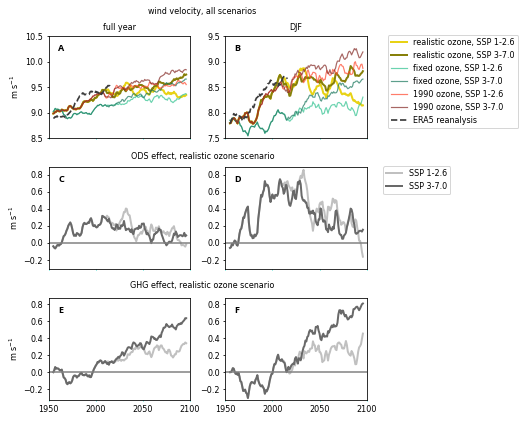

'./figs/RMF-1-hq.pdf'

In [102]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

# Specify the paths to the Noto Sans font files
noto_sans_regular = "/gpfs/home/mep22dku/scratch/Noto_Sans/static/NotoSans-Regular.ttf"
noto_sans_bold = "/gpfs/home/mep22dku/scratch/Noto_Sans/static/NotoSans-Bold.ttf"

# Create FontProperties objects for Noto Sans
noto_font_regular = font_manager.FontProperties(fname=noto_sans_regular)
noto_font_bold = font_manager.FontProperties(fname=noto_sans_bold)

# Disable LaTeX rendering
plt.rcParams['text.usetex'] = False

# Update rcParams to use the Noto Sans font globally
plt.rcParams.update({
    'font.size': 8,
    'font.family': noto_font_regular.get_name(),  # Set the font family globally
})

fs = 8

fig, axs = plt.subplots(3,2, figsize=(5.7,6.7), facecolor='w', edgecolor='k')
axs = axs.ravel()
wspdset = [wspd_1A, wspd_1B, wspd_2A, wspd_2B, wspd_3A, wspd_3B]
scens = ['1A', '1B', '2A', '2B', '3A', '3B']
lws = [2, 2, 1.2, 1.2, 1.2, 1.2]
talph = [1, 1, 0.7, 0.7, 0.7, 0.7]
wspd_2A_50 = wspd_2A.sel(time_counter=slice(f'{1950}-01-01', f'{1960}-01-01'))
wspd_2B_50 = wspd_2B.sel(time_counter=slice(f'{1950}-01-01', f'{1960}-01-01'))

wspdset_o3 = [(wspd_1A-wspd_2A),(wspd_1B-wspd_2B)]
scens_o3 = ['1990-fixed \n (high temp.)', '1990-fixed \n (low temp.)','hist.-fixed \n (high temp.)', 'hist.-fixed \n (low temp.)']
scens_o3 = ['ozone depl.-fixed ozone \n (SSP 3-7.0)', 'ozone depl.-fixed ozone \n (SSP 1-2.6)',\
            'ozone rec .-fixed ozone \n (SSP 3-7.0)', 'ozone rec .-fixed ozone \n (SSP 1-2.6)']
lws_o3 = [1, 1, 2.5, 2.5]
talph_o3 = [0.7, 0.7, 1, 1]

cols_o3 = ['#822722', '#FF462B', '#87800A', '#E8D215']
cols_o3 = [ 'silver','dimgrey']
cols_t = ['dimgrey', 'silver']
scens_t = ['fixed ozone - fixed ozone$_\overline{1950-1960}$ \n (SSP 3-7.0)',\
           'fixed ozone - fixed ozone$_\overline{1950-1960}$ \n (SSP 1-2.6)']

var = 'wspd10m'; vardesc = 'wind speed'; ylab = 'm s$^{-1}$'

############## lines
tits = ['full year','DJF','MAM','JJA','SON',]
for i in range(0,5):
    axs[i].set_title(tits[i], fontsize = fs+2)

for x in range(0,6):
    tsc = scens[x]
    wspd = wspdset[x]
    
    tv = wspd[var].groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    tv_rol.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = lws[x], alpha = talph[x], label = scendict[tsc]['name2'])
      
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    tv_rol.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = lws[x], alpha = talph[x], label = scendict[tsc]['name2'])
    
axs[0].plot(tv.year[0:71],ma_all, color = '#3b3b3b', linestyle = '--', linewidth = 1.7, label = 'ERA5 reanalysis')
axs[1].plot(tv.year[0:71],ma_djf, color = '#3b3b3b', linestyle = '--', linewidth = 1.7, label = 'ERA5 reanalysis')

##### ozone effect

scens_o3 = ['SSP 1-2.6', 'SSP 3-7.0']

ind = 2
for x in range(0,2):
    tsc = scens_o3[x]
    wspd = wspdset_o3[x]
    tv = wspd[var].groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    tv_rol.plot(ax = axs[0+ind], color = cols_o3[x], linewidth = lws[x], alpha = talph[x], label = scens_o3[x])    
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    tv_rol.plot(ax = axs[1+ind], color = cols_o3[x], linewidth  = lws[x], alpha = talph[x], label = scens_o3[x])
    
    
#######################
##### temperature effect
scens_t = [ 'SSP 3-7.0','SSP 1-2.6']

ind = 4; tlw = 2

###
tv = wspd_2A[var].groupby('time_counter.year').mean()-\
wspd_2A_50[var].mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
tv_rol.plot(ax = axs[0+ind], color = cols_t[1], linewidth = tlw, alpha = 1, label = scens_t[1])

tv = wspd_2A[var].sel(time_counter=(wspd_2A['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
wspd_2A_50[var].sel(time_counter=(wspd_2A_50['time_counter.season'] == 'DJF')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
tv_rol.plot(ax = axs[1+ind], color = cols_t[1], linewidth = tlw, alpha = 1, label = scens_t[1])

tv = wspd_2B[var].groupby('time_counter.year').mean()-\
wspd_2B_50[var].mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
tv_rol.plot(ax = axs[0+ind], color = cols_t[0], linewidth = tlw, alpha = 1, label = scens_t[0])

tv = wspd_2B[var].sel(time_counter=(wspd_2B['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
wspd_2B_50[var].sel(time_counter=(wspd_2B_50['time_counter.season'] == 'DJF')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
tv_rol.plot(ax = axs[1+ind], color = cols_t[0], linewidth = tlw, alpha = 1, label = scens_t[0])


##################
### titles, etc

for i in range(0,6):
    axs[i].tick_params(axis="x", direction="out", length=1, width=1, color="turquoise")
    #axs[i].grid(alpha = 0.5)
    
for i in range(0,6):
    axs[i].set_xlim([1950,2100])
    axs[i].set_xlabel('')
    
for i in range(1,6):
    axs[i].set_xlim([1950,2100])
    axs[i].set_ylabel('')
    
for i in range(0,6):
    axs[i].axhline(y=0, color = 'grey')
    
lab = ['A','B'] 
ymi = np.array([8.5,7.5])  
hi = 2
for i in range(0,2):
    axs[i].set_ylim([ymi[i],ymi[i]+hi])
    axs[i].text(1960,ymi[i]+0.85*hi,lab[i], fontproperties = noto_font_bold, fontsize = fs+1)
    
lab = ['C','D']  
ymi = np.array([-0.31,-0.31,])  
hi = 1.2
for i in range(0,2):
    axs[i+2].set_ylim([ymi[i],ymi[i]+hi])
    axs[i+2].text(1960,ymi[i]+0.85*hi,lab[i], fontproperties = noto_font_bold, fontsize = fs+1)
    
lab = ['E','F']  
ymi = np.array([-0.33,-0.33,])  
for i in range(0,2):
    axs[i+4].set_ylim([ymi[i],ymi[i]+hi])
    axs[i+4].text(1960,ymi[i]+0.85*hi,lab[i], fontproperties = noto_font_bold, fontsize = fs+1)

tits = ['full year','DJF','MAM','JJA','SON',]
for i in range(0,2):
    axs[i].set_title(tits[i], fontsize = fs)

axs[0].set_ylabel('m s$^{-1}$')
axs[2].set_ylabel('m s$^{-1}$')
axs[4].set_ylabel('m s$^{-1}$')

axs[0].legend(bbox_to_anchor = [3.35,1.05])
axs[2].legend(bbox_to_anchor = [2.87,1.05])

for i in range(0,4):
    axs[i].set_xticklabels([])


t1 = 'wind velocity, all scenarios'
t2 = 'ODS effect, realistic ozone scenario'
t3 = 'GHG effect, realistic ozone scenario'

plt.subplots_adjust(hspace = 0.28 )
plt.subplots_adjust(wspace = 0.25 )
plt.figtext(0.5,0.94, t1, ha="center", va="top", fontsize=fs, color="k")
plt.figtext(0.5,0.64, t2, ha="center", va="top", fontsize=fs, color="k")
plt.figtext(0.5,0.373, t3, ha="center", va="top", fontsize=fs, color="k")

for i in range(0,6):
    axs[i].tick_params(axis='y', length=2)

# plt.tight_layout()
fname = './figs/RMF-1.jpg'
fig.savefig(fname, transparent=None, dpi=300, format=None,
        metadata=None, bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto', backend=None,\
       )

plt.show()

import jpgtopdf as jp
jp.convert_jpg_to_pdf('./figs/RMF-1.jpg', './figs/RMF-1-hq.pdf')



### calculate trend sizes by season and 50-years for supplement table

In [103]:

import pymannkendall as mk
from scipy import stats

def give_trends(ts_y):

    ts_x = np.arange(0,len(ts_y))
    trend, h, mk_p, z, Tau, s, var_s, mk_slope, intercept = mk.original_test(ts_y)
    lin_slope, intercept, r_value, lin_p, std_err = stats.linregress(ts_x,ts_y)
    
    return mk_slope, mk_p, lin_slope, lin_p



In [104]:
tdar = [wspd_2A, wspd_1A, wspd_3A, wspd_2B, wspd_1B, wspd_3B]

sinds = [0,50,100]
einds = [50,100,150]
for w in range(0,3):
    
    sind = sinds[w]
    eind = einds[w]

    data = np.zeros([5,6])
    sig = np.zeros([5,6])

    for i in range(0,6):

        tdat = tdar[i]
        td = tdat
        td = td.wspd10m.groupby('time_counter.year').mean().values[sind:eind]
        mk_slope, mk_p, lin_slope, lin_p = give_trends(td)
        data[0,i] = lin_slope* 10
        sig[0,i] = lin_p


        td = tdat
        td = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'DJF')).\
        groupby('time_counter.year').mean().values[sind:eind]
        mk_slope, mk_p, lin_slope, lin_p = give_trends(td)
        data[1,i] = lin_slope* 10
        sig[1,i] = lin_p


        td = tdat
        td = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'MAM')).\
        groupby('time_counter.year').mean().values[sind:eind]
        mk_slope, mk_p, lin_slope, lin_p = give_trends(td)
        data[2,i] = lin_slope* 10
        sig[2,i] = lin_p

        td = tdat
        td = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'JJA')).\
        groupby('time_counter.year').mean().values[sind:eind]
        mk_slope, mk_p, lin_slope, lin_p = give_trends(td)
        data[3,i] = lin_slope* 10
        sig[3,i] = lin_p

        td = tdat
        td = td.wspd10m.sel(time_counter=(td['time_counter.season'] == 'SON')).\
        groupby('time_counter.year').mean().values[sind:eind]
        mk_slope, mk_p, lin_slope, lin_p = give_trends(td)
        data[4,i] = lin_slope * 10
        sig[4,i] = lin_p


        i = i+1


    df = pd.DataFrame(data, columns=['2A','1A','3A','2B','1B','3B'],\
                      index  = ['full year','DJF','MAM', 'JJA', 'SON',])
    df2 = pd.DataFrame(sig, columns=['2A','1A','3A','2B','1B','3B'],\
                      index  = ['full year','DJF','MAM', 'JJA', 'SON',])

    df.attrs = {"made in": 'plottingCode/Fig-means-extremes.ipynb'}
    df.to_csv(f'./figs/Fig1-trends-{1950+sind}-{1950+eind}.csv')
    df2.attrs = {"made in": 'plottingCode/Fig-means-extremes.ipynb'}
    df2.to_csv(f'./figs/Fig1-trendsig-{1950+sind}-{1950+eind}.csv')

    print(df)

                 2A        1A        3A        2B        1B        3B
full year -0.009782  0.063205  0.066654 -0.009782  0.063205  0.066654
DJF       -0.042000  0.121807  0.126688 -0.042000  0.121807  0.126688
MAM       -0.000399  0.031277  0.019486 -0.000399  0.031277  0.019486
JJA       -0.000500  0.005949  0.021518 -0.000500  0.005949  0.021518
SON        0.003773  0.093785  0.098925  0.003773  0.093785  0.098925
                 2A        1A        3A        2B        1B        3B
full year  0.035808  0.022432  0.042329  0.051855  0.039205  0.063201
DJF        0.046908  0.002365  0.077933  0.091163  0.041685  0.119694
MAM        0.051708  0.042937  0.039307  0.066554  0.060209  0.064752
JJA        0.034806  0.031909 -0.001524  0.042105  0.005594  0.023296
SON        0.009811  0.012517  0.053601  0.007596  0.049333  0.045064
                 2A        1A        3A        2B        1B        3B
full year  0.015641 -0.019958  0.021029  0.071768  0.062436  0.062794
DJF        0.038726 

### calculate end of century warming effect sizes referenced in text

In [105]:
tv = wspd_2A[var].groupby('time_counter.year').mean()-\
wspd_2A_50[var].mean().values

print(np.nanmean(tv[140:150]))

tv = wspd_2B[var].groupby('time_counter.year').mean()-\
wspd_2B_50[var].mean().values

print(np.nanmean(tv[140:150]))

wspd_1A = xr.open_dataset(f'{baseDir}/UKESM_1A_wspd10m_overwater-50S-mean.nc')
wspd_1B = xr.open_dataset(f'{baseDir}/UKESM_1B_wspd10m_overwater-50S-mean.nc')

tvA = wspd_1A.groupby('time_counter.year').mean()
tvB = wspd_1B.groupby('time_counter.year').mean()
print(np.nanmean(tvA[var][140:150].values)-np.nanmean(tvA[var][0:10].values))

print(np.nanmean(tvB[var][140:150].values)-np.nanmean(tvB[var][0:10].values))


0.34858731010905064
0.6328398798458046
0.3452476784960279
0.7504957544735653


# SF - wind by season

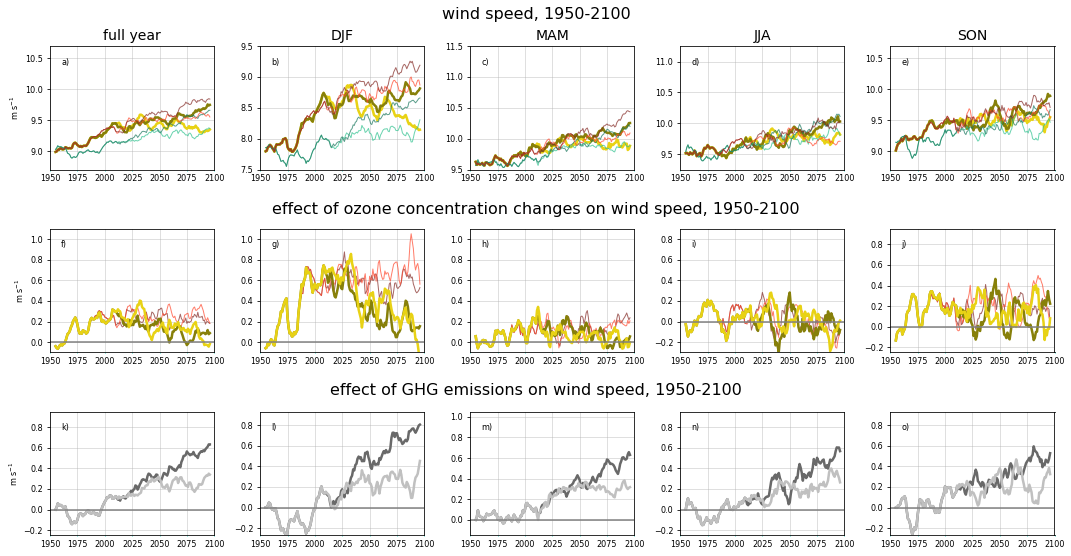

In [106]:
#plt.rc('font', **font)

fs = 16
fact = 1
fig, axs = plt.subplots(3,5, figsize=(18*fact, 9*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
wspdset = [wspd_1A, wspd_1B, wspd_2A, wspd_2B, wspd_3A, wspd_3B]
scens = ['1A', '1B', '2A', '2B', '3A', '3B']
lws = [2.5, 2.5, 1, 1, 1, 1]
talph = [1, 1, 0.7, 0.7, 0.7, 0.7]
wspd_2A_50 = wspd_2A.sel(time_counter=slice(f'{1950}-01-01', f'{1960}-01-01'))
wspd_2B_50 = wspd_2B.sel(time_counter=slice(f'{1950}-01-01', f'{1960}-01-01'))

wspdset_o3 = [(wspd_3B-wspd_2B), (wspd_3A-wspd_2A), (wspd_1B-wspd_2B), (wspd_1A-wspd_2A)]
scens_o3 = ['1990-fixed \n (high temp.)', '1990-fixed \n (low temp.)','hist.-fixed \n (high temp.)', 'hist.-fixed \n (low temp.)']
scens_o3 = ['ozone depl.-fixed ozone \n (SSP 3-7.0)', 'ozone depl.-fixed ozone \n (SSP 1-2.6)',\
            'ozone rec .-fixed ozone \n (SSP 3-7.0)', 'ozone rec .-fixed ozone \n (SSP 1-2.6)']
lws_o3 = [1, 1, 2.5, 2.5]
talph_o3 = [0.7, 0.7, 1, 1]

cols_o3 = ['#822722', '#FF462B', '#87800A', '#E8D215']
cols_t = ['dimgrey', 'silver']
scens_t = ['fixed ozone - fixed ozone$_\overline{1950-1960}$ \n (SSP 3-7.0)',\
           'fixed ozone - fixed ozone$_\overline{1950-1960}$ \n (SSP 1-2.6)']

var = 'wspd10m'; vardesc = 'wind speed'; ylab = 'm s$^{-1}$'

############## lines
tits = ['full year','DJF','MAM','JJA','SON',]
for i in range(0,5):
    axs[i].set_title(tits[i])

for x in range(0,6):
    tsc = scens[x]
    wspd = wspdset[x]
    
    tv = wspd[var].groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = lws[x], alpha = talph[x], label = scendict[tsc]['name2'])
      
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = lws[x], alpha = talph[x], label = scendict[tsc]['name2'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[2], color = scendict[tsc]['color'], linewidth =  lws[x], alpha = talph[x], label = scendict[tsc]['name'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[2], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[3], color = scendict[tsc]['color'], linewidth  = lws[x], alpha = talph[x], label = scendict[tsc]['name'])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[3], color = scendict[tsc]['color'], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[4], color = scendict[tsc]['color'], linewidth  = lws[x], alpha = talph[x])

##########################
# #### ozone effect

ind = 5
for x in range(0,4):
    tsc = scens_o3[x]
    wspd = wspdset_o3[x]
    tv = wspd[var].groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[0+ind], color = cols_o3[x], linewidth = lws_o3[x], alpha = talph_o3[x], label = scens_o3[x])    
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[1+ind], color = cols_o3[x], linewidth  = lws_o3[x], alpha = talph_o3[x], label = scens_o3[x])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[1+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[2+ind], color = cols_o3[x], linewidth  = lws_o3[x], alpha = talph_o3[x], label = scens_o3[x])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[2+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[3+ind], color = cols_o3[x], linewidth  = lws_o3[x], alpha = talph_o3[x])
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    #tv.plot(ax = axs[3+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
    tv_rol.plot(ax = axs[4+ind], color = cols_o3[x], linewidth  = lws_o3[x], alpha = talph_o3[x])
    
# ######################
# #### temperature effect
ind = 10; tlw = 2.5
tv = wspd_2B[var].groupby('time_counter.year').mean()-\
wspd_2B_50[var].mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[0+ind], color = cols_t[0], linewidth = tlw, alpha = 1, label = scens_t[0])

tv = wspd_2B[var].sel(time_counter=(wspd_2B['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
wspd_2B_50[var].sel(time_counter=(wspd_2B_50['time_counter.season'] == 'DJF')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[1+ind], color = cols_t[0], linewidth = tlw, alpha = 1, label = scens_t[0])

tv = wspd_2B[var].sel(time_counter=(wspd_2B['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()-\
wspd_2B_50[var].sel(time_counter=(wspd_2B_50['time_counter.season'] == 'MAM')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[2+ind], color = cols_t[0], linewidth = tlw, alpha = 1, label = scens_t[0])
    
tv = wspd_2B[var].sel(time_counter=(wspd_2B['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()-\
wspd_2B_50[var].sel(time_counter=(wspd_2B_50['time_counter.season'] == 'JJA')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[3+ind], color = cols_t[0], linewidth = tlw, alpha = 1, label = scens_t[0])

tv = wspd_2B[var].sel(time_counter=(wspd_2B['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()-\
wspd_2B_50[var].sel(time_counter=(wspd_2B_50['time_counter.season'] == 'SON')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[4+ind], color = cols_t[0], linewidth = tlw, alpha = 1, label = scens_t[0])    
    
tv = wspd_2A[var].groupby('time_counter.year').mean()-\
wspd_2A_50[var].mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[0+ind], color = cols_t[1], linewidth = tlw, alpha = 1, label = scens_t[1])

tv = wspd_2A[var].sel(time_counter=(wspd_2A['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
wspd_2A_50[var].sel(time_counter=(wspd_2A_50['time_counter.season'] == 'DJF')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[1+ind], color = cols_t[1], linewidth = tlw, alpha = 1, label = scens_t[1])

tv = wspd_2A[var].sel(time_counter=(wspd_2A['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean()-\
wspd_2A_50[var].sel(time_counter=(wspd_2A_50['time_counter.season'] == 'MAM')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[2+ind], color = cols_t[1], linewidth = tlw, alpha = 1, label = scens_t[1])
    
tv = wspd_2A[var].sel(time_counter=(wspd_2A['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean()-\
wspd_2A_50[var].sel(time_counter=(wspd_2A_50['time_counter.season'] == 'JJA')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[3+ind], color = cols_t[1], linewidth = tlw, alpha = 1, label = scens_t[1])

tv = wspd_2A[var].sel(time_counter=(wspd_2A['time_counter.season'] == 'SON')).groupby('time_counter.year').mean()-\
wspd_2A_50[var].sel(time_counter=(wspd_2A_50['time_counter.season'] == 'SON')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
#tv.plot(ax = axs[0+ind], color = cols[x], linewidth = tlw2, alpha = 0.5)
tv_rol.plot(ax = axs[4+ind], color = cols_t[1], linewidth = tlw, alpha = 1, label = scens_t[1])  
#############################################


##################
### titles, etc

t1 = 'wind speed, 1950-2100'
t2 = 'effect of ozone concentration changes on wind speed, 1950-2100'
t3 = 'effect of GHG emissions on wind speed, 1950-2100'
t4 = 'effect of ozone concentration changes and GHG emissions on wind speed, $\overline{2090-2100} - \overline{1950-1960}$'

for i in range(0,15):
    axs[i].tick_params(axis="x", direction="out", length=1, width=1, color="turquoise")
    axs[i].grid(alpha = 0.5)
    
for i in range(0,15):
    axs[i].set_xlim([1950,2100])
    axs[i].set_xlabel('')
    
for i in range(1,15):
    axs[i].set_xlim([1950,2100])
    axs[i].set_ylabel('')
    
for i in range(0,15):
    axs[i].axhline(y=0, color = 'grey')
    
lab = ['a)','b)','c)','d)','e)',] 
ymi = np.array([8.7,7.5,9.5,9.25,8.7])  
hi = 2
for i in range(0,5):
    axs[i].set_ylim([ymi[i],ymi[i]+hi])
    axs[i].text(1960,ymi[i]+0.85*hi,lab[i])
    
lab = ['f)','g)','h)','i)','j)']  
ymi = np.array([-0.1,-0.1,-0.1,-0.3,-0.25])  
hi = 1.2
for i in range(0,5):
    axs[i+5].set_ylim([ymi[i],ymi[i]+hi])
    axs[i+5].text(1960,ymi[i]+0.85*hi,lab[i])
    
lab = ['k)','l)','m)','n)','o)']  
ymi = np.array([-0.25,-0.27,-0.15,-0.25,-0.27])  
for i in range(0,5):
    axs[i+10].set_ylim([ymi[i],ymi[i]+hi])
    axs[i+10].text(1960,ymi[i]+0.85*hi,lab[i])
    
lab = ['p)','q)','r)','s)','t)']  
ymi = np.array([-0.2,-0.2,-0.2,-0.2,-0.2])
hi = 1.1


tits = ['full year','DJF','MAM','JJA','SON',]
for i in range(0,5):
    axs[i].set_title(tits[i], fontsize = fs-2)

plt.subplots_adjust(hspace = 0.48 )
plt.subplots_adjust(wspace = 0.28 )
t1 = 'wind speed, 1950-2100'
t2 = 'effect of ozone concentration changes on wind speed, 1950-2100'
t3 = 'effect of GHG emissions on wind speed, 1950-2100'

axs[0].set_ylabel('m s$^{-1}$')
axs[5].set_ylabel('m s$^{-1}$')
axs[10].set_ylabel('m s$^{-1}$')


fs = 16
plt.subplots_adjust(hspace = 0.48 )
plt.subplots_adjust(wspace = 0.28 )
plt.figtext(0.5,0.94, t1, ha="center", va="top", fontsize=fs, color="k")
plt.figtext(0.5,0.64, t2, ha="center", va="top", fontsize=fs, color="k")
plt.figtext(0.5,0.36, t3, ha="center", va="top", fontsize=fs, color="k")


fname = './figs/SF-windspeed.jpg'
fig.savefig(fname, transparent=None, dpi=250, format=None,
        metadata=None, bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto', backend=None,
       )

# SF  u velocity at 40-60S

In [107]:
def make_yearlist_UKESM(yrst, yrend, scen = '1A'):
    
    baseDir = '//gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/UKESM3M'

    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/UKESM_{scen}_y{yrs[i]}_wspd10m_seas_rg.nc'#_UKESM_wind_daily_1x1_{yrs[i]}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

def get_seas_mean(yr, scen = '1A'):
    
    tdir = '/gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/UKESM3M/'
    
    savenam = (f'{tdir}UKESM_{scen}_y{yr}_wspd10m_seas_rg.nc')
    print(savenam)
    w = xr.open_mfdataset(make_yearlist_UKESM_seas(yr, yr, scen))
    tvar = 'wspd10m'
    djf = w[tvar].sel(time_counter=(w['time_counter.season'] == 'DJF')).values
    mam = w[tvar].sel(time_counter=(w['time_counter.season'] == 'MAM')).values
    jja = w[tvar].sel(time_counter=(w['time_counter.season'] == 'JJA')).values
    son = w[tvar].sel(time_counter=(w['time_counter.season'] == 'SON')).values

    seasns_wspd10m = np.zeros([4,180,360])
    seasns_wspd10m[0,:,:] = np.nanmean(djf, axis = 0)
    seasns_wspd10m[1,:,:] = np.nanmean(mam, axis = 0)
    seasns_wspd10m[2,:,:] = np.nanmean(jja, axis = 0)
    seasns_wspd10m[3,:,:] = np.nanmean(son, axis = 0)

    tvar = 'u10m'
    djf = w[tvar].sel(time_counter=(w['time_counter.season'] == 'DJF')).values
    mam = w[tvar].sel(time_counter=(w['time_counter.season'] == 'MAM')).values
    jja = w[tvar].sel(time_counter=(w['time_counter.season'] == 'JJA')).values
    son = w[tvar].sel(time_counter=(w['time_counter.season'] == 'SON')).values

    seasns_u10m = np.zeros([4,180,360])
    seasns_u10m[0,:,:] = np.nanmean(djf, axis = 0)
    seasns_u10m[1,:,:] = np.nanmean(mam, axis = 0)
    seasns_u10m[2,:,:] = np.nanmean(jja, axis = 0)
    seasns_u10m[3,:,:] = np.nanmean(son, axis = 0)

    tvar = 'v10m'
    djf = w[tvar].sel(time_counter=(w['time_counter.season'] == 'DJF')).values
    mam = w[tvar].sel(time_counter=(w['time_counter.season'] == 'MAM')).values
    jja = w[tvar].sel(time_counter=(w['time_counter.season'] == 'JJA')).values
    son = w[tvar].sel(time_counter=(w['time_counter.season'] == 'SON')).values

    seasns_v10m = np.zeros([4,180,360])
    seasns_v10m[0,:,:] = np.nanmean(djf, axis = 0)
    seasns_v10m[1,:,:] = np.nanmean(mam, axis = 0)
    seasns_v10m[2,:,:] = np.nanmean(jja, axis = 0)
    seasns_v10m[3,:,:] = np.nanmean(son, axis = 0)

    times = pd.to_datetime([f"{yr}-01-15", f"{yr}-04-15", f"{yr}-07-15", f"{yr}-10-15"])

    data_vars = {'wspd10m':(['time_counter', 'lat', 'lon'], seasns_wspd10m,
    {'units': 'm/s',
    'long_name':'10m wspd regridded'}),
                 'u10m':(['time_counter', 'lat', 'lon'], seasns_u10m,
    {'units': 'm/s',
    'long_name':'10m u component regridded'}),
                 'v10m':(['time_counter', 'lat', 'lon'], seasns_v10m,
    {'units': 'm/s',
    'long_name':'10m v component regridded'}),
    }
    # define coordinates
    coords = {'time_counter': (['time_counter'], times),

    'lon': (['lon'], w.lon.values),
    'lat': (['lat'], w.lat.values),
    }
    # define global attributes
    attrs = {'made in':'/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/windBandSensitivity/windbandtest.ipynb',

    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)

    ds.to_netcdf(savenam)     

ex = False

if ex:
    #'1A','1B',
    scens = ['1A','1B','2A','2B','3A','3B']
    for scen in scens:
        for y in range(1950,2101):
            get_seas_mean(y, scen = scen)

In [108]:
savenam = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
cdomask = xr.open_dataset(savenam)
tmask = cdomask.tmask

extract = False


def get_ukesmwinds(varname = 'wspd10m', blind = 0, tlind = 40, nam = 'overwater-50S'):
    

    ylist_UKESM_1A = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '1A'))
    ylist_UKESM_2A = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '2A'))
    ylist_UKESM_3A = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '3A'))
    ylist_UKESM_1B = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '1B'))
    ylist_UKESM_2B = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '2B'))
    ylist_UKESM_3B = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '3B'))

    savenam = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
    cdomask = xr.open_dataset(savenam)
    tmask = cdomask.tmask
    
    t1 = 1950; t2 = 2101
    baseDir = '//gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'

    print(f'{baseDir}')
    print(f'UKESM_1A')
    test = ylist_UKESM_1A[varname].sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(blind,tlind)).weighted(tmask.isel(lat = slice(blind,tlind)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = varname)
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_1A_{varname}_{nam}-mean.nc')
    

    test = ylist_UKESM_2A[varname].sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(blind,tlind)).weighted(tmask.isel(lat = slice(blind,tlind)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = varname)
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_2A_{varname}_{nam}-mean.nc')

    test = ylist_UKESM_3A[varname].sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(blind,tlind)).weighted(tmask.isel(lat = slice(blind,tlind)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = varname)
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_3A_{varname}_{nam}-mean.nc')
    ##
    test = ylist_UKESM_1B[varname].sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(blind,tlind)).weighted(tmask.isel(lat = slice(blind,tlind)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = varname)
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_1B_{varname}_{nam}-mean.nc')

    test = ylist_UKESM_2B[varname].sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(blind,tlind)).weighted(tmask.isel(lat = slice(blind,tlind)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = varname)
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_2B_{varname}_{nam}-mean.nc')

    print(f'UKESM_3B')
    test = ylist_UKESM_3B[varname].sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(blind,tlind)).weighted(tmask.isel(lat = slice(blind,tlind)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = varname)
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_3B_{varname}_{nam}-mean.nc')
    print(f'UKESM_3B_{varname}_{nam}-mean.nc')
        
if extract:
    
    
    get_ukesmwinds(varname = 'wspd10m', blind = 0, tlind = 40, nam = '50S-90S')
    get_ukesmwinds(varname = 'wspd10m', blind = 30, tlind = 50, nam = '40S-60S')
    get_ukesmwinds(varname = 'wspd10m', blind = 35, tlind = 45, nam = '45S-55S')

    #get_ukesmwinds(varname = 'u10m', blind = 0, tlind = 40, nam = '50S-90S')
    get_ukesmwinds(varname = 'u10m', blind = 30, tlind = 50, nam = '40S-60S')
    get_ukesmwinds(varname = 'u10m', blind = 35, tlind = 45, nam = '45S-55S')
    


In [109]:
def get_winds(nam,varname,save = True, var = 'wspd10m', \
              vardesc = 'wind speed',\
              baseDir = '//gpfs/data/greenocean2/software/products/windsFromComponents/dailyStandard/intProc/'):

    wspd_1A = xr.open_dataset(f'{baseDir}/UKESM_1A_{varname}_{nam}-mean.nc')
    wspd_2A = xr.open_dataset(f'{baseDir}/UKESM_2A_{varname}_{nam}-mean.nc')
    wspd_3A = xr.open_dataset(f'{baseDir}/UKESM_3A_{varname}_{nam}-mean.nc')
    wspd_1B = xr.open_dataset(f'{baseDir}/UKESM_1B_{varname}_{nam}-mean.nc')
    wspd_2B = xr.open_dataset(f'{baseDir}/UKESM_2B_{varname}_{nam}-mean.nc')
    wspd_3B = xr.open_dataset(f'{baseDir}/UKESM_3B_{varname}_{nam}-mean.nc')

    ylims = True

    fs=16

    fact = 1.1
    fig, axs = plt.subplots(3,2, figsize=(7*fact, 8.35*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    wspdset = [wspd_1A, wspd_1B, wspd_2A, wspd_2B, wspd_3A, wspd_3B]
    scens = ['1A', '1B', '2A', '2B', '3A', '3B']
    lws = [2.5, 2.5, 1, 1, 1, 1]
    talph = [1, 1, 0.7, 0.7, 0.7, 0.7]
    wspd_2A_50 = wspd_2A.sel(time_counter=slice(f'{1950}-01-01', f'{1960}-01-01'))
    wspd_2B_50 = wspd_2B.sel(time_counter=slice(f'{1950}-01-01', f'{1960}-01-01'))

    wspdset_o3 = [(wspd_1A-wspd_2A),(wspd_1B-wspd_2B)]
    scens_o3 = ['1990-fixed \n (high temp.)', '1990-fixed \n (low temp.)','hist.-fixed \n (high temp.)', 'hist.-fixed \n (low temp.)']
    scens_o3 = ['ozone depl.-fixed ozone \n (SSP 3-7.0)', 'ozone depl.-fixed ozone \n (SSP 1-2.6)',\
                'ozone rec .-fixed ozone \n (SSP 3-7.0)', 'ozone rec .-fixed ozone \n (SSP 1-2.6)']
    lws_o3 = [1, 1, 2.5, 2.5]
    talph_o3 = [0.7, 0.7, 1, 1]

    cols_o3 = ['#822722', '#FF462B', '#87800A', '#E8D215']
    cols_o3 = [ 'silver','dimgrey']
    cols_t = ['dimgrey', 'silver']
    scens_t = ['fixed ozone - fixed ozone$_\overline{1950-1960}$ \n (SSP 3-7.0)',\
               'fixed ozone - fixed ozone$_\overline{1950-1960}$ \n (SSP 1-2.6)']

    ylab = 'm s$^{-1}$'

    ############## lines
    tits = ['full year','DJF','MAM','JJA','SON',]
    for i in range(0,5):
        axs[i].set_title(tits[i])

    for x in range(0,6):
        tsc = scens[x]
        wspd = wspdset[x]

        tv = wspd[var].groupby('time_counter.year').mean()
        tv_rol = tv.rolling(year=10, center=True).mean()
        tv_rol.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = lws[x], alpha = talph[x], label = scendict[tsc]['name2'])

        tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
        tv_rol = tv.rolling(year=10, center=True).mean()
        tv_rol.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = lws[x], alpha = talph[x], label = scendict[tsc]['name2'])

    # axs[0].plot(tv.year[0:71],ma_all, color = '#3b3b3b', linestyle = '--', linewidth = 1.7, label = 'ERA5 reanalysis')
    # axs[1].plot(tv.year[0:71],ma_djf, color = '#3b3b3b', linestyle = '--', linewidth = 1.7, label = 'ERA5 reanalysis')

    ##### ozone effect

    scens_o3 = ['SSP 1-2.6', 'SSP 3-7.0']

    ind = 2
    for x in range(0,2):
        tsc = scens_o3[x]
        wspd = wspdset_o3[x]
        tv = wspd[var].groupby('time_counter.year').mean()
        tv_rol = tv.rolling(year=10, center=True).mean()
        tv_rol.plot(ax = axs[0+ind], color = cols_o3[x], linewidth = lws[x], alpha = talph[x], label = scens_o3[x])    

        tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
        tv_rol = tv.rolling(year=10, center=True).mean()
        tv_rol.plot(ax = axs[1+ind], color = cols_o3[x], linewidth  = lws[x], alpha = talph[x], label = scens_o3[x])


    #######################
    ##### temperature effect
    scens_t = [ 'SSP 3-7.0','SSP 1-2.6']

    ind = 4; tlw = 2.5

    ###
    tv = wspd_2A[var].groupby('time_counter.year').mean()-\
    wspd_2A_50[var].mean().values
    tv_rol = tv.rolling(year=10, center=True).mean()
    tv_rol.plot(ax = axs[0+ind], color = cols_t[1], linewidth = tlw, alpha = 1, label = scens_t[1])

    tv = wspd_2A[var].sel(time_counter=(wspd_2A['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
    wspd_2A_50[var].sel(time_counter=(wspd_2A_50['time_counter.season'] == 'DJF')).mean().values
    tv_rol = tv.rolling(year=10, center=True).mean()
    tv_rol.plot(ax = axs[1+ind], color = cols_t[1], linewidth = tlw, alpha = 1, label = scens_t[1])

    tv = wspd_2B[var].groupby('time_counter.year').mean()-\
    wspd_2B_50[var].mean().values
    tv_rol = tv.rolling(year=10, center=True).mean()
    tv_rol.plot(ax = axs[0+ind], color = cols_t[0], linewidth = tlw, alpha = 1, label = scens_t[0])

    tv = wspd_2B[var].sel(time_counter=(wspd_2B['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
    wspd_2B_50[var].sel(time_counter=(wspd_2B_50['time_counter.season'] == 'DJF')).mean().values
    tv_rol = tv.rolling(year=10, center=True).mean()
    tv_rol.plot(ax = axs[1+ind], color = cols_t[0], linewidth = tlw, alpha = 1, label = scens_t[0])


    ##################
    ### titles, etc

    for i in range(0,6):
        axs[i].tick_params(axis="x", direction="out", length=1, width=1, color="turquoise")
        axs[i].grid(alpha = 0.5)

    for i in range(0,6):
        axs[i].set_xlim([1950,2100])
        axs[i].set_xlabel('')

    for i in range(1,6):
        axs[i].set_xlim([1950,2100])
        axs[i].set_ylabel('')

    for i in range(2,6):
        axs[i].axhline(y=0, color = 'grey')

    lab = ['a)','b)'] 
    ymi = np.array([5.45,5.1])  
    hi = 1.2
    if ylims:
        for i in range(0,2):
            axs[i].set_ylim([ymi[i],ymi[i]+hi])
            axs[i].text(1960,ymi[i]+0.85*hi,lab[i])

    lab = ['c)','d)']  
    ymi = np.array([-0.28,-0.28,])  
    hi = 1.2
    if ylims:
        for i in range(0,2):
            axs[i+2].set_ylim([ymi[i],ymi[i]+hi])
            axs[i+2].text(1960,ymi[i]+0.85*hi,lab[i])

    lab = ['e)','f)']  
    ymi = np.array([-0.47,-0.47,])  
    if ylims:

        for i in range(0,2):
            axs[i+4].set_ylim([ymi[i],ymi[i]+hi])
            axs[i+4].text(1960,ymi[i]+0.85*hi,lab[i])

    tits = ['full year','DJF','MAM','JJA','SON',]
    for i in range(0,2):
        axs[i].set_title(tits[i], fontsize = fs-2)

    axs[0].set_ylabel('m s$^{-1}$')
    axs[2].set_ylabel('m s$^{-1}$')
    axs[4].set_ylabel('m s$^{-1}$')

    axs[0].legend(bbox_to_anchor = [3.35,1.05])
    axs[2].legend(bbox_to_anchor = [2.9,1.05])

    for i in range(0,4):
        axs[i].set_xticklabels([])

    fs = 16

    t1 = f'{nam} {varname}, all scenarios'
    t2 = 'ozone effect, realistic ozone scenario'
    t3 = 'GHG effect, realistic ozone scenario'

    plt.subplots_adjust(hspace = 0.28 )
    plt.subplots_adjust(wspace = 0.25 )
    plt.figtext(0.5,0.94, t1, ha="center", va="top", fontsize=fs, color="k")
    plt.figtext(0.5,0.64, t2, ha="center", va="top", fontsize=fs, color="k")
    plt.figtext(0.5,0.373, t3, ha="center", va="top", fontsize=fs, color="k")

    plt.tight_layout()
    if save:
        fname = f'./figs/SF-{nam}-{varname}.jpg'
        print(fname)# = f'./plts/MF-{nam}-{varname}.jpg'
        fig.savefig(fname, transparent=None, dpi=250, format=None,
                metadata=None, bbox_inches='tight', pad_inches=0.1,
                facecolor='auto', edgecolor='auto', backend=None,
               )

./figs/SF-40S-60S-u10m.jpg


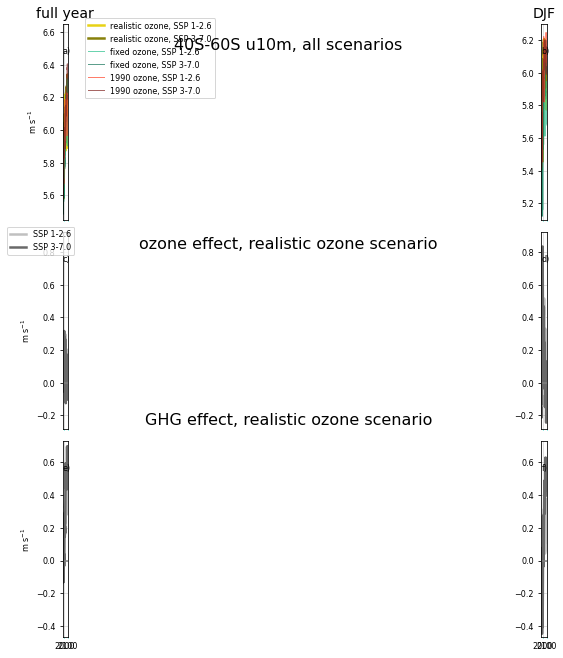

In [110]:
varname = 'u10m'
bd = '/gpfs/home/mep22dku/scratch/SO-wind-feedback/data/SF-u10wind/'
nam = '40S-60S'
get_winds(nam,varname,save = True, var = varname, baseDir = bd)

### not used - 40-60S wind speed

In [111]:
savenam = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
cdomask = xr.open_dataset(savenam)
tmask = cdomask.tmask

extract = False

if extract:
    
    ylist_UKESM_1A = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '1A'))
    ylist_UKESM_2A = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '2A'))
    ylist_UKESM_3A = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '3A'))
    ylist_UKESM_1B = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '1B'))
    ylist_UKESM_2B = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '2B'))
    ylist_UKESM_3B = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, '3B'))
    ylist_UKESM_PI = xr.open_mfdataset(make_yearlist_UKESM(1950,2100, 'PI'))

    savenam = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
    cdomask = xr.open_dataset(savenam)
    tmask = cdomask.tmask
    
    t1 = 1950; t2 = 2101
    baseDir = '//gpfs/data/greenocean/software/products/windsFromComponents/symlinked_hrly_UKESM/daily/'

    test = ylist_UKESM_1A.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(30,50)).weighted(tmask.isel(lat = slice(30,50)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = 'wspd10m')
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_1A_wspd10m_overwater-40-60S-mean.nc')

    test = ylist_UKESM_2A.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(30,50)).weighted(tmask.isel(lat = slice(30,50)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = 'wspd10m')
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_2A_wspd10m_overwater-40-60S-mean.nc')

    test = ylist_UKESM_3A.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(30,50)).weighted(tmask.isel(lat = slice(30,50)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = 'wspd10m')
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_3A_wspd10m_overwater-40-60S-mean.nc')
    ##
    test = ylist_UKESM_1B.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(30,50)).weighted(tmask.isel(lat = slice(30,50)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = 'wspd10m')
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_1B_wspd10m_overwater-40-60S-mean.nc')

    test = ylist_UKESM_2B.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(30,50)).weighted(tmask.isel(lat = slice(30,50)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = 'wspd10m')
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_2B_wspd10m_overwater-40-60S-mean.nc')

    test = ylist_UKESM_3B.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(30,50)).weighted(tmask.isel(lat = slice(30,50)))\
    .mean(dim = ['lat', 'lon'])
    test3 = test2.to_dataset(name = 'wspd10m')
    test3.attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/Fig-line-windeffect.ipynb'}
    test3.to_netcdf(f'{baseDir}/UKESM_3B_wspd10m_overwater-40-60S-mean.nc')
    print('done')

In [112]:
baseDir = '//gpfs/data/greenocean/software/products/windsFromComponents/symlinked_hrly_UKESM/daily/'

wspd_1A = xr.open_dataset(f'{baseDir}/UKESM_1A_wspd10m_overwater-40-60S-mean.nc')
wspd_2A = xr.open_dataset(f'{baseDir}/UKESM_2A_wspd10m_overwater-40-60S-mean.nc')
wspd_3A = xr.open_dataset(f'{baseDir}/UKESM_3A_wspd10m_overwater-40-60S-mean.nc')
wspd_1B = xr.open_dataset(f'{baseDir}/UKESM_1B_wspd10m_overwater-40-60S-mean.nc')
wspd_2B = xr.open_dataset(f'{baseDir}/UKESM_2B_wspd10m_overwater-40-60S-mean.nc')
wspd_3B = xr.open_dataset(f'{baseDir}/UKESM_3B_wspd10m_overwater-40-60S-mean.nc')

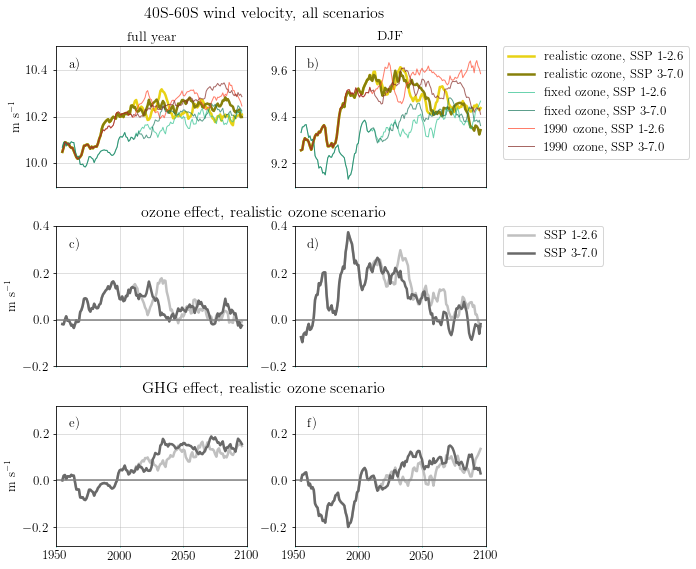

In [113]:
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

fs=16

fact = 1.1
fig, axs = plt.subplots(3,2, figsize=(7*fact, 8.35*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
wspdset = [wspd_1A, wspd_1B, wspd_2A, wspd_2B, wspd_3A, wspd_3B]
scens = ['1A', '1B', '2A', '2B', '3A', '3B']
lws = [2.5, 2.5, 1, 1, 1, 1]
talph = [1, 1, 0.7, 0.7, 0.7, 0.7]
wspd_2A_50 = wspd_2A.sel(time_counter=slice(f'{1950}-01-01', f'{1960}-01-01'))
wspd_2B_50 = wspd_2B.sel(time_counter=slice(f'{1950}-01-01', f'{1960}-01-01'))

wspdset_o3 = [(wspd_1A-wspd_2A),(wspd_1B-wspd_2B)]
scens_o3 = ['1990-fixed \n (high temp.)', '1990-fixed \n (low temp.)','hist.-fixed \n (high temp.)', 'hist.-fixed \n (low temp.)']
scens_o3 = ['ozone depl.-fixed ozone \n (SSP 3-7.0)', 'ozone depl.-fixed ozone \n (SSP 1-2.6)',\
            'ozone rec .-fixed ozone \n (SSP 3-7.0)', 'ozone rec .-fixed ozone \n (SSP 1-2.6)']
lws_o3 = [1, 1, 2.5, 2.5]
talph_o3 = [0.7, 0.7, 1, 1]

cols_o3 = ['#822722', '#FF462B', '#87800A', '#E8D215']
cols_o3 = [ 'silver','dimgrey']
cols_t = ['dimgrey', 'silver']
scens_t = ['fixed ozone - fixed ozone$_\overline{1950-1960}$ \n (SSP 3-7.0)',\
           'fixed ozone - fixed ozone$_\overline{1950-1960}$ \n (SSP 1-2.6)']

var = 'wspd10m'; vardesc = 'wind speed'; ylab = 'm s$^{-1}$'

############## lines
tits = ['full year','DJF','MAM','JJA','SON',]
for i in range(0,5):
    axs[i].set_title(tits[i])

for x in range(0,6):
    tsc = scens[x]
    wspd = wspdset[x]
    
    tv = wspd[var].groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    tv_rol.plot(ax = axs[0], color = scendict[tsc]['color'], linewidth = lws[x], alpha = talph[x], label = scendict[tsc]['name2'])
      
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    tv_rol.plot(ax = axs[1], color = scendict[tsc]['color'], linewidth = lws[x], alpha = talph[x], label = scendict[tsc]['name2'])
    
# axs[0].plot(tv.year[0:71],ma_all, color = '#3b3b3b', linestyle = '--', linewidth = 1.7, label = 'ERA5 reanalysis')
# axs[1].plot(tv.year[0:71],ma_djf, color = '#3b3b3b', linestyle = '--', linewidth = 1.7, label = 'ERA5 reanalysis')

##### ozone effect

scens_o3 = ['SSP 1-2.6', 'SSP 3-7.0']

ind = 2
for x in range(0,2):
    tsc = scens_o3[x]
    wspd = wspdset_o3[x]
    tv = wspd[var].groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    tv_rol.plot(ax = axs[0+ind], color = cols_o3[x], linewidth = lws[x], alpha = talph[x], label = scens_o3[x])    
    
    tv = wspd[var].sel(time_counter=(wspd['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()
    tv_rol = tv.rolling(year=10, center=True).mean()
    tv_rol.plot(ax = axs[1+ind], color = cols_o3[x], linewidth  = lws[x], alpha = talph[x], label = scens_o3[x])
    
    
#######################
##### temperature effect
scens_t = [ 'SSP 3-7.0','SSP 1-2.6']

ind = 4; tlw = 2.5

###
tv = wspd_2A[var].groupby('time_counter.year').mean()-\
wspd_2A_50[var].mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
tv_rol.plot(ax = axs[0+ind], color = cols_t[1], linewidth = tlw, alpha = 1, label = scens_t[1])

tv = wspd_2A[var].sel(time_counter=(wspd_2A['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
wspd_2A_50[var].sel(time_counter=(wspd_2A_50['time_counter.season'] == 'DJF')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
tv_rol.plot(ax = axs[1+ind], color = cols_t[1], linewidth = tlw, alpha = 1, label = scens_t[1])

tv = wspd_2B[var].groupby('time_counter.year').mean()-\
wspd_2B_50[var].mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
tv_rol.plot(ax = axs[0+ind], color = cols_t[0], linewidth = tlw, alpha = 1, label = scens_t[0])

tv = wspd_2B[var].sel(time_counter=(wspd_2B['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean()-\
wspd_2B_50[var].sel(time_counter=(wspd_2B_50['time_counter.season'] == 'DJF')).mean().values
tv_rol = tv.rolling(year=10, center=True).mean()
tv_rol.plot(ax = axs[1+ind], color = cols_t[0], linewidth = tlw, alpha = 1, label = scens_t[0])


##################
### titles, etc

for i in range(0,6):
    axs[i].tick_params(axis="x", direction="out", length=1, width=1, color="turquoise")
    axs[i].grid(alpha = 0.5)
    
for i in range(0,6):
    axs[i].set_xlim([1950,2100])
    axs[i].set_xlabel('')
    
for i in range(1,6):
    axs[i].set_xlim([1950,2100])
    axs[i].set_ylabel('')
    
for i in range(0,6):
    axs[i].axhline(y=0, color = 'grey')
    
lab = ['a)','b)'] 
ymi = np.array([9.9,9.1])  
hi = 0.6
for i in range(0,2):
    axs[i].set_ylim([ymi[i],ymi[i]+hi])
    axs[i].text(1960,ymi[i]+0.85*hi,lab[i])
    
lab = ['c)','d)']  
ymi = np.array([-0.2,-0.2,])  
hi = 0.6
for i in range(0,2):
    axs[i+2].set_ylim([ymi[i],ymi[i]+hi])
    axs[i+2].text(1960,ymi[i]+0.85*hi,lab[i])
    
lab = ['e)','f)']  
ymi = np.array([-0.28,-0.28,])  
for i in range(0,2):
    axs[i+4].set_ylim([ymi[i],ymi[i]+hi])
    axs[i+4].text(1960,ymi[i]+0.85*hi,lab[i])

tits = ['full year','DJF','MAM','JJA','SON',]
for i in range(0,2):
    axs[i].set_title(tits[i], fontsize = fs-2)

axs[0].set_ylabel('m s$^{-1}$')
axs[2].set_ylabel('m s$^{-1}$')
axs[4].set_ylabel('m s$^{-1}$')

axs[0].legend(bbox_to_anchor = [3.35,1.05])
axs[2].legend(bbox_to_anchor = [2.9,1.05])

for i in range(0,4):
    axs[i].set_xticklabels([])

fs = 16

t1 = '40S-60S wind velocity, all scenarios'
t2 = 'ozone effect, realistic ozone scenario'
t3 = 'GHG effect, realistic ozone scenario'

plt.subplots_adjust(hspace = 0.28 )
plt.subplots_adjust(wspace = 0.25 )
plt.figtext(0.5,0.94, t1, ha="center", va="top", fontsize=fs, color="k")
plt.figtext(0.5,0.64, t2, ha="center", va="top", fontsize=fs, color="k")
plt.figtext(0.5,0.373, t3, ha="center", va="top", fontsize=fs, color="k")

plt.tight_layout()
fname = './figs/SF-windspeed-40-60S.jpg'
# fig.savefig(fname, transparent=None, dpi=250, format=None,
#         metadata=None, bbox_inches='tight', pad_inches=0.1,
#         facecolor='auto', edgecolor='auto', backend=None,
#        )